<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/6.9.3.4-LSTMB16_dr20_rdr20_batch128_lr001-GloVe_with_stop_nonlemmatized-500k-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained GloVe embedding using LSTM with 500k samples without removing stop words

For this notebook, we will use 500k samples using architecture that was suggested by Wanliang Tan et al in [Sentiment Analysis for Amazon Reviews](http://cs229.stanford.edu/proj2018/report/122.pdf)

In this paper, they were able to achieve test set accuracy of 70%:
* Glove embedding with 300 dimension vectors
* max sequence length of 100 words (this is same as what we've been doing)
* 128 LSTM hidden units with 0.2 dropout rate
* learning rate of 0.01
* batch size of 32
* 20 epochs
* 37k samples


I want to see if we can generate similar results using the same network architecture with our dataset

Score for previous runs: 0.2959231917086992


# Result

Our score: 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/device:GPU:0'

In [2]:
# check what GPU we got
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# check that we are using high RAM runtime
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Fri May  8 13:32:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"


DEBUG = False


LSTM_DIM = 16 # total LSTM units
# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.2
RECURRENT_DROPOUT_RATE = 0.2
PATIENCE = 4
BIDIRECTIONAL = False
BALANCE_CLASS_WEIGHTS = True
TRAIN_EMBEDDINGS = False


# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100

if BIDIRECTIONAL:
  bidirectional_name = "bi"
else:
  bidirectional_name = ""

if BALANCE_CLASS_WEIGHTS:
  balanced_name = "B"
else:
  balanced_name = ""

MODEL_NAME = f"{bidirectional_name}LSTM{balanced_name}{LSTM_DIM}"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units, Dropout {DROPOUT_RATE}, Recurrent Dropout {RECURRENT_DROPOUT_RATE}, Batch Size {BATCH_SIZE}, Learning Rate {LEARNING_RATE}"
FEATURE_SET_NAME = "glove_with_stop_nonlemmatized"

SAMPLES = "500k"

REPORT_FILE = f"{MODEL_NAME}_" \
              f"dr{ku.get_decimal_str(DROPOUT_RATE)}_" \
              f"rdr{ku.get_decimal_str(RECURRENT_DROPOUT_RATE)}_" \
              f"batch{BATCH_SIZE}_" \
              f"lr{ku.get_decimal_str(LEARNING_RATE)}-{FEATURE_SET_NAME}-dl_prototype-report.csv"

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
  ku.ModelWrapper.set_report_filename(f"test-{REPORT_FILE}")

else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-with_stop_nonlemmatized-preprocessed.csv"
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename(REPORT_FILE)



EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'

start_time = datetime.now()






/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[FEATURE_COLUMN]

# Preprocessing

In [5]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer(oov_token="<UNK>")
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=80202
Number of Documents=374123
Train review vectors shape: (374123, 100)  Test review vectors shape: (124708, 100)


## Load our pre-trained embedding

embeddings_index will be a map where key == word, value == the embedding vector

In [6]:

EMBEDDING_INDEX_FILE = f'{DRIVE_DIR}/models/glove.840B.300d-embedding_index'

embeddings_index = {}

if os.path.exists(f'{EMBEDDING_INDEX_FILE}.npy'):
  print(f'Loading {EMBEDDING_INDEX_FILE}.npy')
  embeddings_index = np.load(f'{EMBEDDING_INDEX_FILE}.npy', 
                             allow_pickle = True).item()
else:
  print('Indexing word vectors.')

  with open(EMBEDDING_FILE) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, 'f', sep=' ')
          embeddings_index[word] = coefs
  np.save(EMBEDDING_INDEX_FILE, embeddings_index)

print(type(embeddings_index))
print(np.shape(embeddings_index))
print('Found %s word vectors.' % len(embeddings_index))




Loading drive/My Drive/Springboard/capstone/models/glove.840B.300d-embedding_index.npy
<class 'dict'>
()
Found 2195884 word vectors.


## Create Embedding Matrix based on our tokenizer

For every word in our vocabulary, we will look up the embedding vector and add the it to our embedding matrix

The matrix will be passed in as weights in our embedding layer later

If there is word that does not exist in the pre-trained embedding vocabulary, we will leave the weights as 0 vector and save off the word into a CSV file later for analysis

In [7]:
# this is a map with key == word, value == index in the vocabulary
word_index = t.word_index
print(f'word_index length: {len(word_index)}')

# we are going to use the entire vocab so we can alter this from the example
# num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

# start with a matrix of 0's
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

# if a word doesn't exist in our vocabulary, let's save it off
missing_words = []
print(f'embedding_matrix shape: {np.shape(embedding_matrix)}')
for word, i in word_index.items():
    # print(f'word: {word} i: {i}')
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and np.shape(embedding_vector)[0] == EMBED_SIZE:
        # words not found in embedding index will be all-zeros.
        # print(f'i: {i} embedding_vector shape: {np.shape(embedding_vector)}')
        embedding_matrix[i] = embedding_vector
    else:
      missing_words.append(word)

print(f'Number of missing words from our vocabulary: {len(missing_words)}')



word_index length: 80203
embedding_matrix shape: (80204, 300)
Number of missing words from our vocabulary: 25805


Save off our missing words into a csv file so we can analyze this later

In [0]:
# save missing words into a file so we can analyze it later
missing_words_df = pd.DataFrame(missing_words)
missing_words_df.to_csv(MISSING_WORDS_FILE, index=False)

**Build LSTM Model Architecture**

In [9]:
vocab_size = len(t.word_index)+1

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1,
                           restore_best_weights=True)

mw = ku.LSTM1LayerModelWrapper(
                        lstm_dim=LSTM_DIM, # LSTM dim - LSTM1LyerModelWrapper
                          dropout_rate=DROPOUT_RATE, # dropout rate - LSTM1LyerModelWrapper
                          recurrent_dropout_rate=RECURRENT_DROPOUT_RATE, # recurrent dropout rate - LSTM1LyerModelWrapper
                          bidirectional=BIDIRECTIONAL, # bidirectional - LSTM1LyerModelWrapper
                          vocab_size=vocab_size,       # vocab size - EmbeddingModelWrapper
                          max_sequence_length=MAX_SEQUENCE_LENGTH, # max sequence length - EmbeddingModelWrapper
                          embed_size=EMBED_SIZE, # embed size - EmbeddingModelWrapper
                        train_embeddings=TRAIN_EMBEDDINGS, # trainable embedding - EmbeddingModelWrapper
                        model_name=MODEL_NAME, # model name - ModelWrapper
                        architecture=ARCHITECTURE, # architecture - ModelWrapper
                        feature_set_name=FEATURE_SET_NAME, # feature_set_name - ModelWrapper
                        label_column=LABEL_COLUMN, # label_column - ModelWrapper
                        feature_column=FEATURE_COLUMN, # feature_column - ModelWrapper
                        data_file=DATA_FILE, # data file - ModelWrapper
                        tokenizer = t, # tokenizer - ModelWrapper
                        description = DESCRIPTION, #description - ModelWrapper
                        learning_rate = LEARNING_RATE, # learning rate - ModelWrapper
                        optimizer = "Adam"
)



mw.add("environment", "6.9.3.4-LSTMB16_dr20_rdr20_batch128_lr001-GloVe_with_stop_nonlemmatized-500k-prototype.ipynb")
mw.add("patience", PATIENCE)

network_history = mw.fit(X_train, y_train,
                      batch_size = BATCH_SIZE,
                      epochs = EPOCHS,
                      verbose = 1,
                      validation_split = 0.2,
                      balance_class_weights = BALANCE_CLASS_WEIGHTS,
                      callbacks=[early_stop, reduce_lr])

                      

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          24061200  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                20288     
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 24,081,573
Trainable params: 20,373
Non-trainable params: 24,061,200
_________________________________________________________________
Build model:
None
Epoch 1/20
2339/2339 [==============================] - 641s 274ms/step - loss: 1.3768 - categorical_accuracy: 0.4902 - val_loss: 1.1578 - val_categorical_accuracy: 0.5635 - lr: 0.0010
Epoch 2/20
2339/2339 [==============================] - 638s 273ms/step - loss: 1.2937 - categorical_accuracy: 0.5304 - val_loss: 1.1362 - val_categorical_accuracy: 0

Number of test: 124708
Running model.evaluate on test set...
3898/3898 [==============================] - 96s 25ms/step - loss: 0.9427 - categorical_accuracy: 0.6235
Running model.predict on test set...
Unencode test set predictions...
Generating test set confusion matrix...
Calculating test set ROC AUC...
(124708, 5)
Getting test set classification report...
Running model.evaluate on training set...
11692/11692 [==============================] - 284s 24ms/step - loss: 0.9353 - categorical_accuracy: 0.6266
Running model.predict on training set...
Unencode training set predictions...
Generating training set confusion matrix...
Calculating training set ROC AUC...
(374123, 5)
Getting training set classification report...
Training Accuracy: 62.66%
Test Accuracy: 62.35%


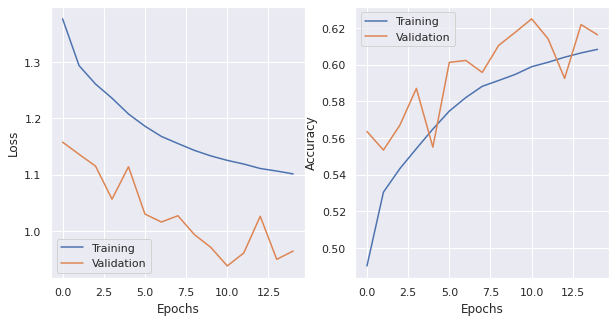


Confusion Matrix
[[10788  4166  1320   479   682]
 [ 2078  2950  2010   690   403]
 [  869  2266  4599  2516  1004]
 [  351   911  3504  8892  7163]
 [  952  1195  2554 11834 50532]]

Classification Report
              precision    recall  f1-score   support

           1       0.72      0.62      0.66     17435
           2       0.26      0.36      0.30      8131
           3       0.33      0.41      0.36     11254
           4       0.36      0.43      0.39     20821
           5       0.85      0.75      0.80     67067

    accuracy                           0.62    124708
   macro avg       0.50      0.51      0.50    124708
weighted avg       0.66      0.62      0.64    124708



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

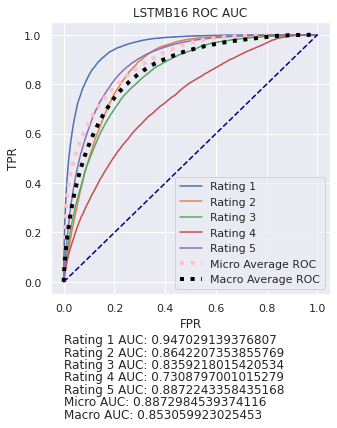

In [10]:

scores = mw.evaluate(X_test, y_test)
print("Training Accuracy: %.2f%%" % (mw.train_scores[1]*100))
print("Test Accuracy: %.2f%%" % (mw.test_scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.test_confusion_matrix)

print("\nClassification Report")
print(mw.test_classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.test_roc_auc, mw.test_fpr, mw.test_tpr)



In [11]:
print(f'Score: {ru.calculate_metric(mw.test_crd)}')

Score: 0.48336698777467973


**Save off various files**

In [12]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB16-1x16-dr2-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-498831-100-review_body
Saving to report file: drive/My Drive/Springboard/capstone/reports/LSTMB16_dr2_rdr2_batch128_lr001-glove_with_stop_nonlemmatized-dl_prototype-report.csv
Saving report file...
Saving json config file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-dr2-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-498831-100-review_body-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-dr2-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-498831-100-review_body-weights.h5
Saving history file: drive/My Drive/Springboard/capstone/reports/LSTMB16-1x16-dr2-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-498831-100-review_body-history.pkl
Saving model file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-dr2-rdr2-batch128-lr001-glove_with_stop_nonlemmatized-sampling_none-498831-100-review_body

# Test That Our Models Saved Correctly

In [13]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


3898/3898 [==============================] - 95s 24ms/step - loss: 0.9427 - categorical_accuracy: 0.6235
Accuracy: 62.35%


In [14]:
end_time = datetime.now()
print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
print(f"Total Duraction {round((end_time - start_time).total_seconds() / 60, 2)} mins")

Start Time: 2020-05-08 13:32:43.257380
End Time: 2020-05-08 16:30:48.842858
Total Duraction 178.09 mins
